# Statistics Pipeline

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import ast
import math
import scipy.stats as stats
import preprocessing_helper

import statsmodels.formula.api as smf

## Table of Contents

* [Initial analysis & plots](#Initial)
    * [Actor gender distributions](#distributions_gender)
    * [Age and gender](#age_gender)
    * [Age distribution](#age_dist)
    * [Movies released by year](#movie_year)
    * [IMDB ratings over all movies](#IMDB)
    * [Revenue and ratings of all movies](#revenu)
    * [Summaries](#sum)
    * [Characters and actors](#char_act)    
    * [Romance and ratings](#rom_rate)  
* [Persona explanation and overview](#persona)
    * [Case study : Persona 35](#35)
    * [Persona and genres](#persona_genre)
    * [Persona and romancer](#Persona_romance)

In [2]:
path_lda = './Data/LDA/'

characters = pd.read_csv('./Data/Preprocessed/preprocessed_characters.tsv', delimiter='\t')
summaries = pd.read_csv('./Data/MovieSummaries/plot_summaries.txt', sep="\t", names=['movie_id', 'summary'])
movies = pd.read_csv('./Data/Preprocessed/movie.metadata.augmented.tsv', delimiter='\t')

movies['genres'] = movies['genres'].apply(lambda genre : ast.literal_eval(genre))
movies['languages'] = movies['languages'].apply(lambda language : ast.literal_eval(language))
movies['countries'] = movies['countries'].apply(lambda countries : ast.literal_eval(countries))

### Initial analysis & plots <a class="anchor" id="Initial"></a>

Let's do some general exploratory analysis before diving into our project!

#### Actor gender distributions <a class="anchor" id="distributions_gender"></a>

In [3]:
proportion = characters.groupby(by='movie_release')['a_gender'].value_counts(normalize=True).reset_index()
proportion['percentage'] = proportion['proportion']*100

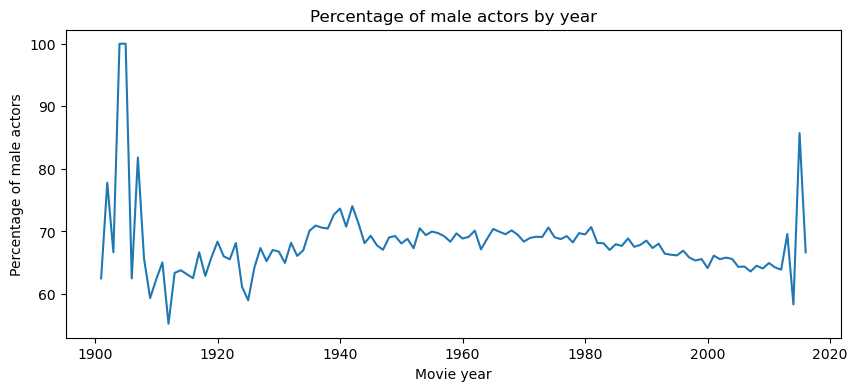

In [4]:
fig = plt.figure(figsize=(10, 4))
plt.title('Percentage of male actors by year')
plt.ylabel('Percentage of male actors')
plt.xlabel('Movie year')
sns.lineplot(proportion[proportion['a_gender']=='M'], x='movie_release', y='percentage')
plt.show()

We can see that apart from a few years before 1900 (where a lot of the gender data was missing), male actors always dominate, with roughly 2/3rds of the roles.

#### Age and gender <a class="anchor" id="age_gender"></a>

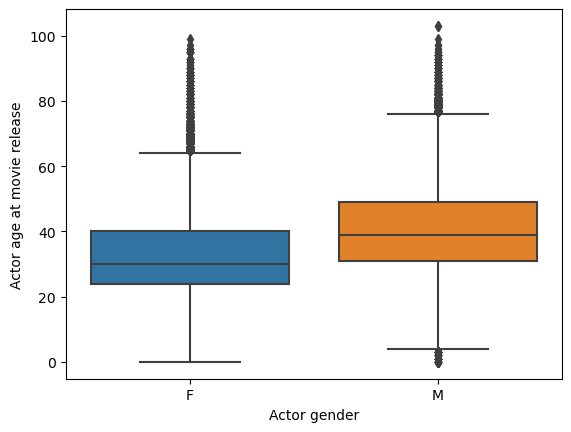

In [5]:
sns.boxplot(data=characters, x='a_gender', y='a_age')
plt.xlabel('Actor gender')
plt.ylabel('Actor age at movie release')
plt.show()

In [6]:
men = characters[characters['a_gender']=='M']
women = characters[characters['a_gender']=='F']
men['a_age'].describe()

count    191255.000000
mean         40.471188
std          13.749397
min           0.000000
25%          31.000000
50%          39.000000
75%          49.000000
max         103.000000
Name: a_age, dtype: float64

In [7]:
women['a_age'].describe()

count    99117.000000
mean        32.956799
std         13.375786
min          0.000000
25%         24.000000
50%         30.000000
75%         40.000000
max         99.000000
Name: a_age, dtype: float64

In [8]:
stats.ttest_ind(men['a_age'].dropna(), women['a_age'].dropna())

TtestResult(statistic=140.93647972290537, pvalue=0.0, df=290370.0)

Since the p value is much lower than 0.05, we can say that the means are different. Let's now have a look at how the age has evolved over time:

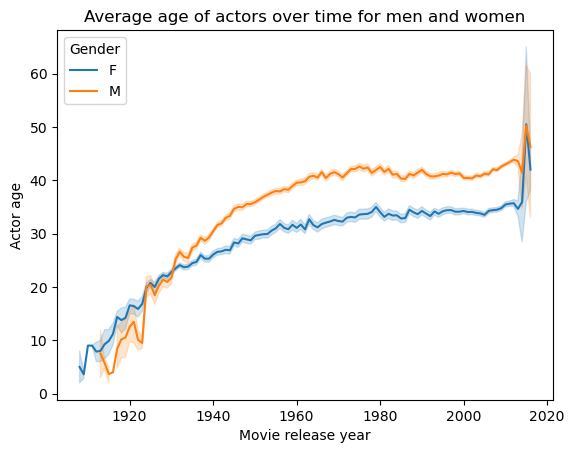

In [9]:
sns.lineplot(characters, x='movie_release', y='a_age', hue='a_gender')
plt.title('Average age of actors over time for men and women')
plt.xlabel('Movie release year')
plt.ylabel('Actor age')
plt.legend(title='Gender', loc='upper left')
plt.show()

We can see that women were older on average until about 1930. Afterwards, men are consistently older than women, with an average around 40 whereas women are on average 30 years old. Note that the confidence intervals are almost completely non-overlapping, which confirms the result of the t-test above.

#### Age distribution <a class="anchor" id="age_dist"></a>

Now let's have a look at the mean and median actor ages over the years:

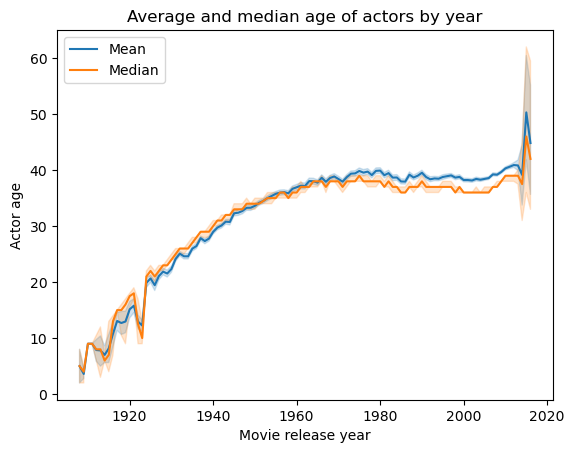

In [10]:
sns.lineplot(characters, x ='movie_release', y = 'a_age', estimator='mean', label='Mean')
sns.lineplot(characters, x ='movie_release', y = 'a_age', estimator='median', label='Median')

plt.title('Average and median age of actors by year')
plt.legend(loc='upper left')
plt.xlabel('Movie release year')
plt.ylabel('Actor age')
plt.show()

#### Movies released by year <a class="anchor" id="movie_year"></a>

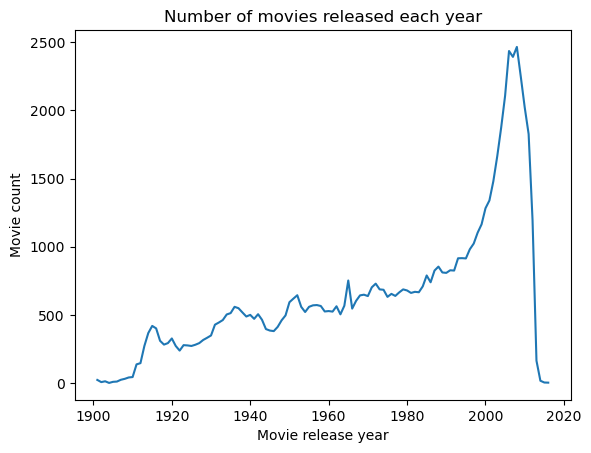

In [11]:
movies_by_year = movies.groupby(by='movie_release')['movie_id'].count().reset_index()
movies_by_year.columns = ['movie_release', 'movie_count']

sns.lineplot(movies_by_year, x ='movie_release', y = 'movie_count')
plt.title('Number of movies released each year')
plt.xlabel('Movie release year')
plt.ylabel('Movie count')
plt.show()

Using the plot of the previous part, we can see that the age of the characters increases until the 70s, then stabilises at around 40. We can also see that the number of films in the dataset has increased significantly. The median age is very close. 
This increase could be explained by the fact that, when the dataset was created, the old actors who played in the oldest films had died and only the best-known of them were considered.

#### IMDB ratings over all movies <a class="anchor" id="IMDB"></a>

First, we wanna look if the average vote is correlated with the number of votes in the imdb ratings of the movies:

In [12]:
ratings_votes = movies[['rating', 'nb_votes']]
ratings_votes = ratings_votes.dropna()
stats.pearsonr(ratings_votes['rating'], ratings_votes['nb_votes'])

PearsonRResult(statistic=0.15385274007287947, pvalue=3.7123380426907094e-284)

The correlation coefficient is very small, so despite the very small p-value, we cannot conclude much of this.

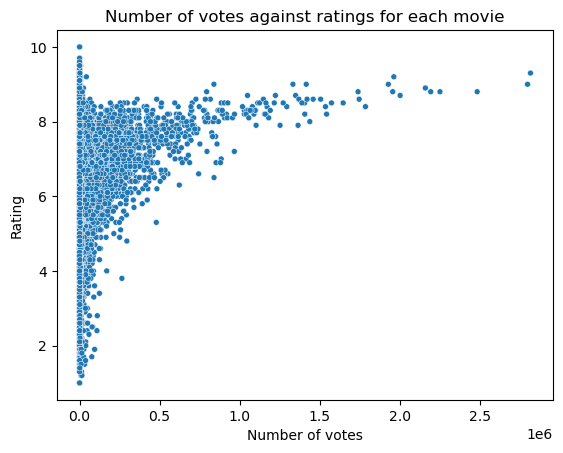

In [13]:
sns.scatterplot(data=ratings_votes, x='nb_votes', y='rating', size=0.1, legend=False)
plt.title('Number of votes against ratings for each movie')
plt.xlabel('Number of votes')
plt.ylabel('Rating')
plt.show()

Let's see if there's anything more we can conclude by looking at the number of votes on a logarithmic scale:

In [14]:
ratings_votes['log_nb_votes'] = ratings_votes['nb_votes'].apply(lambda x: math.log(x))
stats.pearsonr(ratings_votes['rating'], ratings_votes['log_nb_votes'])

PearsonRResult(statistic=0.1264783620758239, pvalue=5.582600993115047e-192)

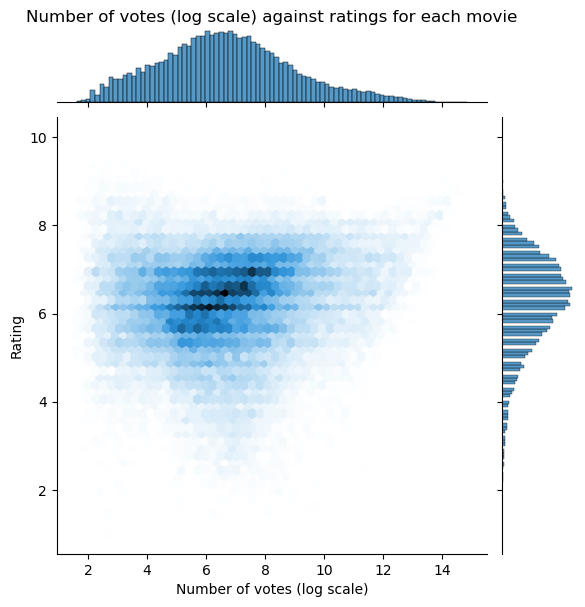

In [15]:
sns.jointplot(data=ratings_votes, x='log_nb_votes', y='rating', kind='hex')
plt.title('Number of votes (log scale) against ratings for each movie', y=1.2)
plt.xlabel('Number of votes (log scale)')
plt.ylabel('Rating')
plt.show()

There's not much to be said for logarithmic observation. We can also look at how ratings evolve over the years. Are recent films rated higher than films from the 80s?

In [16]:
ratings_votes_year = movies[['movie_release', 'rating', 'nb_votes']]
ratings_votes_year = ratings_votes_year.dropna()
stats.pearsonr(ratings_votes_year['rating'], ratings_votes_year['movie_release'])

PearsonRResult(statistic=-0.05603630770239666, pvalue=5.087367896912882e-37)

Again, the p-value is very low, but so is the correlation coefficient, so we cannot conclude anything.

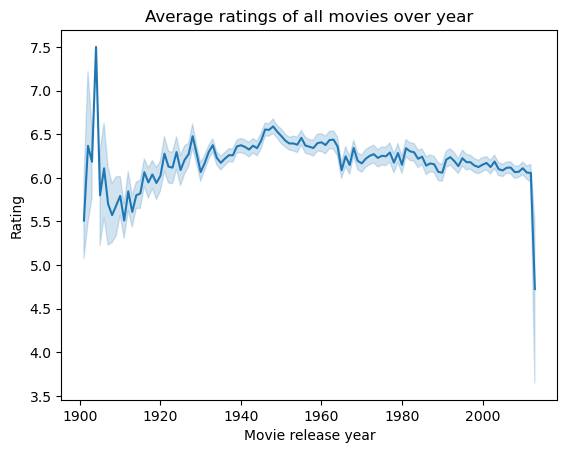

In [17]:
sns.lineplot(data=ratings_votes_year, x='movie_release', y='rating')
plt.title('Average ratings of all movies over year')
plt.xlabel('Movie release year')
plt.ylabel('Rating')
plt.show()

In [18]:
ratings_votes_year['rating'].describe()

count    51382.000000
mean         6.210099
std          1.124616
min          1.000000
25%          5.600000
50%          6.300000
75%          7.000000
max         10.000000
Name: rating, dtype: float64

We see that the average rating of all movies (starting 1920) is relatively constant around 6 over time. The total mean (over all years) is 6.21.

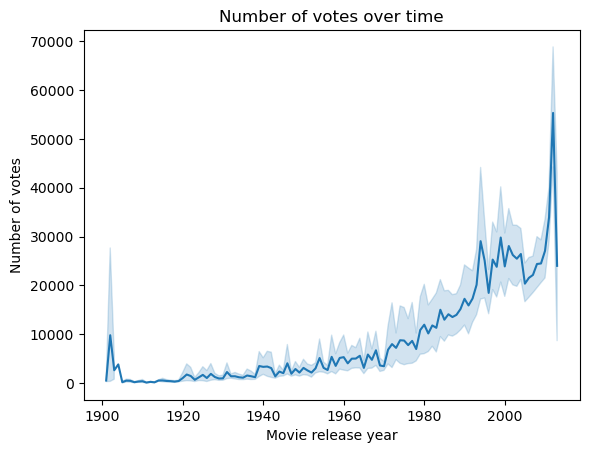

In [19]:
sns.lineplot(data=ratings_votes_year, x='movie_release', y='nb_votes')
plt.title('Number of votes over time')
plt.xlabel('Movie release year')
plt.ylabel('Number of votes')
plt.show()

We can clearly see that the number of votes increases each year. Despite this, as mentioned above, the average film score did not change much between the 1950s and the end of the measures.

#### Revenue and ratings of all movies <a class="anchor" id="revenu"></a>

Despite not having many box office revenue values, let's see if they are correlated with the ratings:

In [20]:
ratings_revenue = movies[['rating', 'revenue']]
ratings_revenue = ratings_revenue.dropna()
stats.pearsonr(ratings_revenue['rating'], ratings_revenue['revenue'])

PearsonRResult(statistic=0.16869636850751937, pvalue=8.910801122086917e-53)

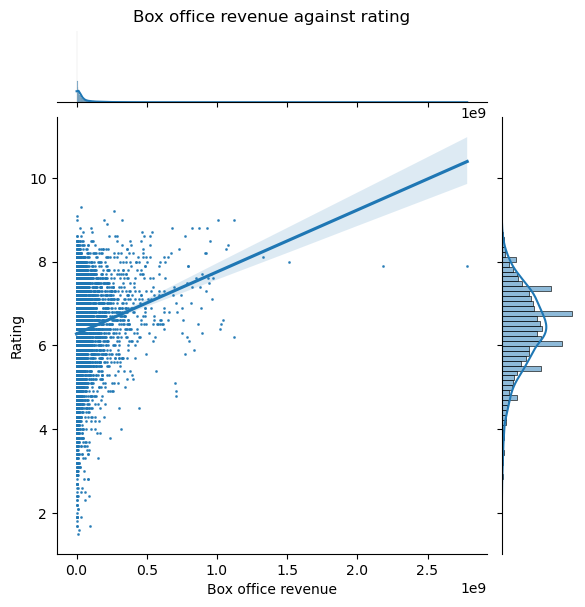

In [21]:
sns.jointplot(data=ratings_revenue, x='revenue', y='rating', kind='reg', scatter_kws={'s': 1})
plt.title('Box office revenue against rating', y=1.2)
plt.xlabel('Box office revenue')
plt.ylabel('Rating')
plt.show()

Visually and since the correlation is very small, we deduce that there is no link between ratings and box office revenue. Therefore, we continue working without the box office revenue as we have very little data for it.

#### Summaries <a class="anchor" id="sum"></a>

Out of all the movies that have summaries, which languages are most common? Let's find out!

In [22]:
movies_with_summaries = movies.merge(summaries, how='left')
summary_movies = movies_with_summaries[movies_with_summaries['summary'].isna()==0]

languages_occurrences_summaries = preprocessing_helper.get_values_occurrences(summary_movies, 'languages')
sorted_common_languages = dict(sorted(languages_occurrences_summaries.items(), key=lambda x:x[1], reverse=True))

list(sorted_common_languages.items())[:5], len(sorted_common_languages)

([('english language', 24785),
  ('hindi language', 2209),
  ('french language', 1985),
  ('spanish language', 1468),
  ('japanese language', 1284)],
 206)

Out of the 206 different languages appearing in movies that have summaries, english movies are by far the most common.

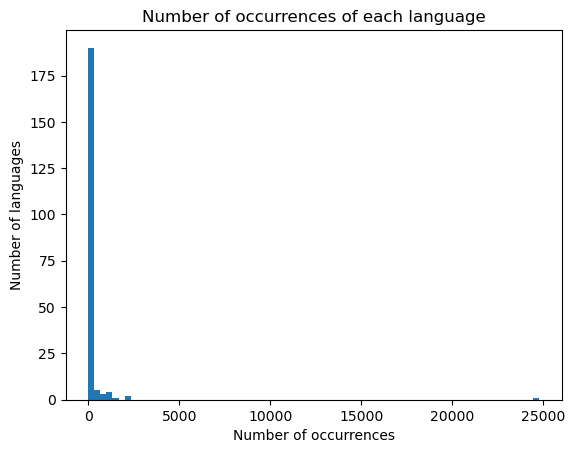

In [23]:
def plot_occurrences_against_languages(dictionary):
    plt.hist(dictionary.values(), bins=75)
    plt.xlabel("Number of occurrences")
    plt.ylabel("Number of languages")
    plt.title("Number of occurrences of each language")
    plt.show()

plot_occurrences_against_languages(sorted_common_languages)

We can see a few things from this plot. Firstly, there is one outlier with almost 25000 occurrences (english, as mentioned above). Secondly, most languages only appear very few times. Let's remove the outlier to get a clearer representation of the rest.

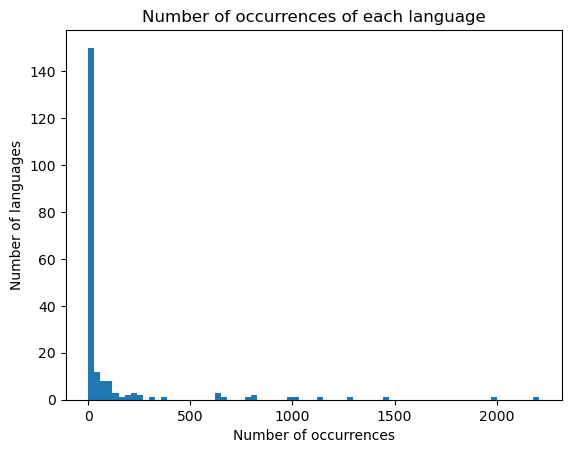

In [24]:
without_outlier = dict(filter(lambda x: x[1]<10000, sorted_common_languages.items()))
plot_occurrences_against_languages(without_outlier)

Now, we can see that a huge majority of movies appear less that 100 times. Let's see how many exactly.

In [25]:
def number_occurrences_in_interval(dictionary, lower_bound, upper_bound):
    return len(dict(filter(lambda x: lower_bound<=x[1]<upper_bound, dictionary.items())))

In [26]:
number_occurrences_in_interval(sorted_common_languages, 0, 100), len(summary_movies)

(173, 42196)

Out of the 206 languages appearing for the 42000 movies with summaries, 172 don't even appear more than 100 times. So for these languages, less than 100 movies out of the 42000 (`len(summary_movies)`) use them. Let's have a look at the languages that are used more:

In [27]:
number_occurrences_in_interval(sorted_common_languages, 100, 1000)

26

In [28]:
number_occurrences_in_interval(sorted_common_languages, 1000, 2500)

6

So 172 languages appeared less than 100 times, 26 appeared between 100 and 1000 times, 7 appeared between 1000 and 2500 times and only the english language appeared more than 2500 times, almost 10 times more with almost 25000 occurrences. Clearly, far more movies in english have summaries. However, let's have a look at how many more movies there are in english overall:

In [29]:
languages_occurrences = preprocessing_helper.get_values_occurrences(movies, 'languages')
languages_sorted = sorted(languages_occurrences.items(), key=lambda x:x[1], reverse=False)
print(len(languages_sorted))
languages_sorted_dec = dict(languages_sorted[::-1])

207


There is only one more language compared to before. So out of all languages we have, there is only one for which the movie(s) have no summary at all. We saw earlier that only about half the movies have summaries, so it makes sense that languages occur far more if we consider all movies rather than just those that have summaries, but here is what the distribution is now:

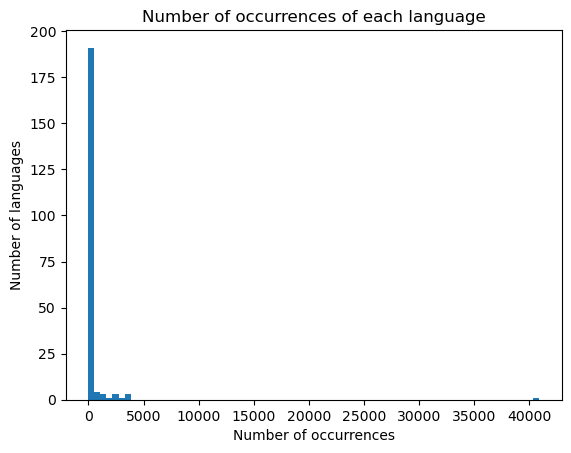

In [30]:
plot_occurrences_against_languages(languages_sorted_dec)

The distribution looks very similar, just on a scale that is about twice as large (since we remove about half the movies when taking only those with summaries). So if we compare the number of occurrences of languages in the same ranges we had before, but multiplied by 2 (because we consider all movies), we get almost exactly the same numbers:

In [31]:
print(number_occurrences_in_interval(languages_sorted_dec, 0, 200))
print(number_occurrences_in_interval(languages_sorted_dec, 200, 2000))
print(number_occurrences_in_interval(languages_sorted_dec, 2000, 5000))

173
26
7


Again, most of the languages appear in less than 200 movies, and only 8 languages appear more than 1000 times altogether (incuding the outlier, english, which appears over 40000 times, this gives 7+1)

#### Characters and actors <a class="anchor" id="char_act"></a>

In order to do our project idea, we need to first have a look at how different roles actors have.

In [32]:
characters.head()

,movie_id,c_name,a_gender,a_name,a_age,c_id,a_id,movie_release,a_birth_year,persona
0,975900,Akooshay,F,Wanda De Jesus,42.0,/m/0bgcj3x,/m/03wcfv7,2001.0,1958.0,NaN
1,975900,Lieutenant Melanie Ballard,F,Natasha Henstridge,27.0,/m/0bgchn4,/m/0346l4,2001.0,1974.0,35.0
2,975900,Desolation Williams,M,Ice Cube,32.0,/m/0bgchn_,/m/01vw26l,2001.0,1969.0,NaN
3,975900,Sgt Jericho Butler,M,Jason Statham,33.0,/m/0bgchnq,/m/034hyc,2001.0,1967.0,NaN
4,975900,Bashira Kincaid,F,Clea DuVall,23.0,/m/0bgchp9,/m/01y9xg,2001.0,1977.0,NaN


In [33]:
number_roles_per_actor = characters.groupby('a_id')['c_id'].nunique().reset_index()
number_roles_per_actor = number_roles_per_actor.rename(columns={"c_id": "nb_roles"})
number_roles_per_actor.head(5)

,a_id,nb_roles
0,/m/010p3,7
1,/m/010q36,0
2,/m/010wx,0
3,/m/010xjr,51
4,/m/0112yl,8


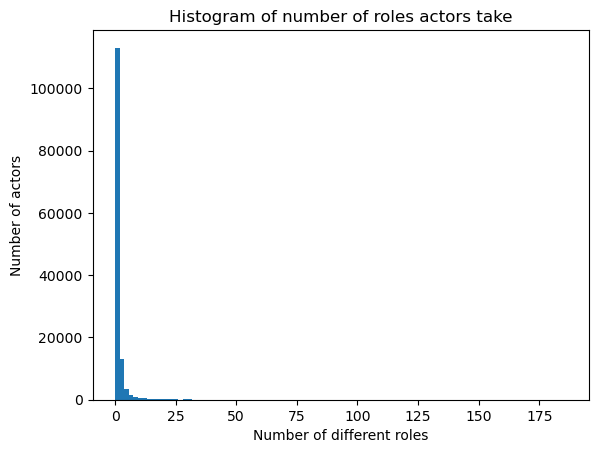

In [34]:
number_roles_per_actor['nb_roles'].plot(kind='hist', bins=100)
plt.ylabel('Number of actors')
plt.xlabel('Number of different roles')
plt.title('Histogram of number of roles actors take')
plt.show()

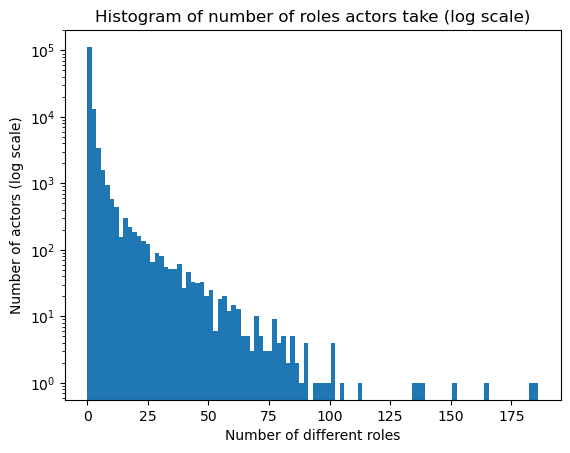

In [35]:
number_roles_per_actor['nb_roles'].plot(kind='hist', bins = 100, logy=True)
plt.ylabel('Number of actors (log scale)')
plt.xlabel('Number of different roles')
plt.title('Histogram of number of roles actors take (log scale)')
plt.show()

In [36]:
number_roles_per_actor['nb_roles'].describe()

count    135319.00000
mean          1.37889
std           4.31935
min           0.00000
25%           0.00000
50%           1.00000
75%           1.00000
max         186.00000
Name: nb_roles, dtype: float64

#### Romance and ratings <a class="anchor" id="rom_rate"></a>

Our analysis consists of looking at movies with "Romance" as one of its genres and see how well they are rated based on the personas, tropes, and potential other genres. So let's start looking at this by first seeing how many movies we have that contain the genre "Romance".

In [37]:
romantic = movies[movies['genres'].apply(lambda genres: 'Romance' in genres)]
len(romantic)

11599

We have 11599 movies with "Romance" in their genres! This is a decent amount for the project. Our project is mainly based on ratings, we want to check how many values actually contain ratings and/or box office revenu (and how many are missing).

In [38]:
def find_missing_percentage(dataframe, column_name):
    missing = dataframe[column_name].isna().sum()
    return missing/len(dataframe[column_name])*100

In [39]:
find_missing_percentage(romantic, 'rating'), find_missing_percentage(romantic, 'revenue')

(27.304077937753256, 80.3689973273558)

We see that we are missing only 27% of the ratings for romance movies, whereas we are missing 80% of the box office revenue data. Clearly, adding ratings was a good choice! Now, since we focus on the ratings, let's try to see how romance movies are rated on imdb and the statistics. First, we notice that there are 8432 (corresponding to the 73% (100-27) mentioned before) movies with ratings.

In [40]:
romantic['rating'].describe()

count    8432.000000
mean        6.292493
std         0.942069
min         1.400000
25%         5.800000
50%         6.400000
75%         6.900000
max         9.200000
Name: rating, dtype: float64

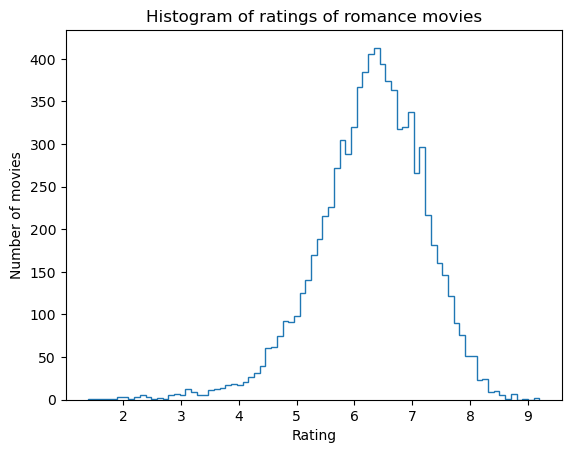

In [41]:
romantic['rating'].hist(bins=79, grid=False, histtype='step')
plt.xlabel('Rating')
plt.ylabel('Number of movies')
plt.title('Histogram of ratings of romance movies')
plt.show()

Let's now have a look at how those ratings evolve over time:

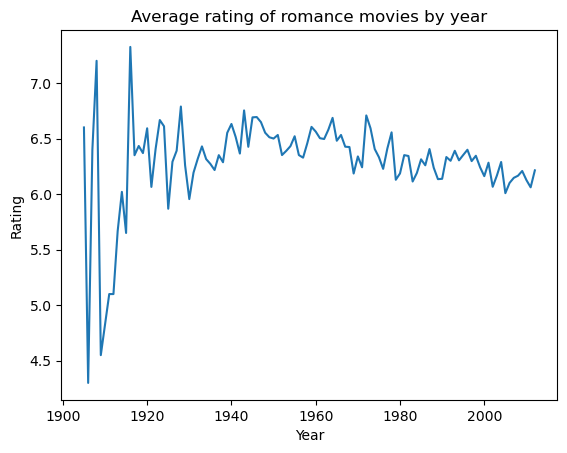

In [42]:
def plot_ratings_by_year(dataframe, title):    
    average_rating_year = dataframe.groupby(by='movie_release')['rating'].mean().reset_index()

    plt.plot(average_rating_year['movie_release'], average_rating_year['rating'])
    plt.xlabel('Year')
    plt.ylabel('Rating')
    plt.title(f'Average rating of {title} movies by year')
    plt.show()

plot_ratings_by_year(romantic, "romance")

We want to see how movies with romance and some other genres are rated. For example, are romance and action movies (both) better rated than romance and comedy? To do so, let's first have a look at the genres we have: which are most common? Which appear with romance at all?

In [43]:
#we create a dictionary mapping genres (each genre contained in the dataframe) to number of occurrences

def get_genres(df):
    total_genres = {}
    for genres in df['genres']:
        for genre in genres:
            total_genres[genre] = total_genres.get(genre, 0)+1
    return total_genres

In [44]:
total_genres = get_genres(movies)

Now that we have each genre and the number of times it occurs, we can find the most common ones by sorting by number of occurrences.

In [45]:
top_genres = sorted(total_genres.items(), key=lambda x:x[1], reverse=True)[:10]
top_genres

[('Drama', 35285),
 ('Comedy', 21645),
 ('Indie', 13282),
 ('Romance', 11599),
 ('Action', 10113),
 ('World Cinema', 9970),
 ('Thriller', 9116),
 ('Black-and-white', 9050),
 ('Adventure', 8919),
 ('Crime', 8137)]

The most common genres are "Drama", "Comedy", "Indie", "Romance", "Action", "World Cinema", "Thriller", "Black-and-white", "Adventure" and "Crime". Those are the ones that appear more than 8500 times, so we focus on those. We want to plot, side by side, the average rating by year of movies with both "Romance" and once of the aforementioned genres (excluding "Romance") below. For this, let's start by making a list of the genres that occur more than 8500 times, excluding "Romance", as follows:

In [46]:
most_common_genres = [top_genre[0] for top_genre in top_genres if top_genre[1]>8500]
most_common_genres.remove('Romance')

Since we will perform multiple types of analysis of movies with "Romance" and "xxx" (one of the other genres), we store these filtered dataframes into a dictionary mapping "xxx" to the dataframe containing movies that had "Romance" and "xxx". Note that the different dataframes are not necessarily disjoint because since movies can contain many different genres, a movie can contain "Romance" and for example "Drama" and "Action" (or any two genres in the list above). In this case the movie would be in the dataframe of both "Drama" and "Action". This is what `get_two_genres` is used for.

In [47]:
def get_two_genres(movies_df):
    two_genres = {}
    for g in most_common_genres:
        two_genres[g] = movies_df[movies_df['genres'].apply(lambda genres: 'Romance' in genres and g in genres)]
    return two_genres

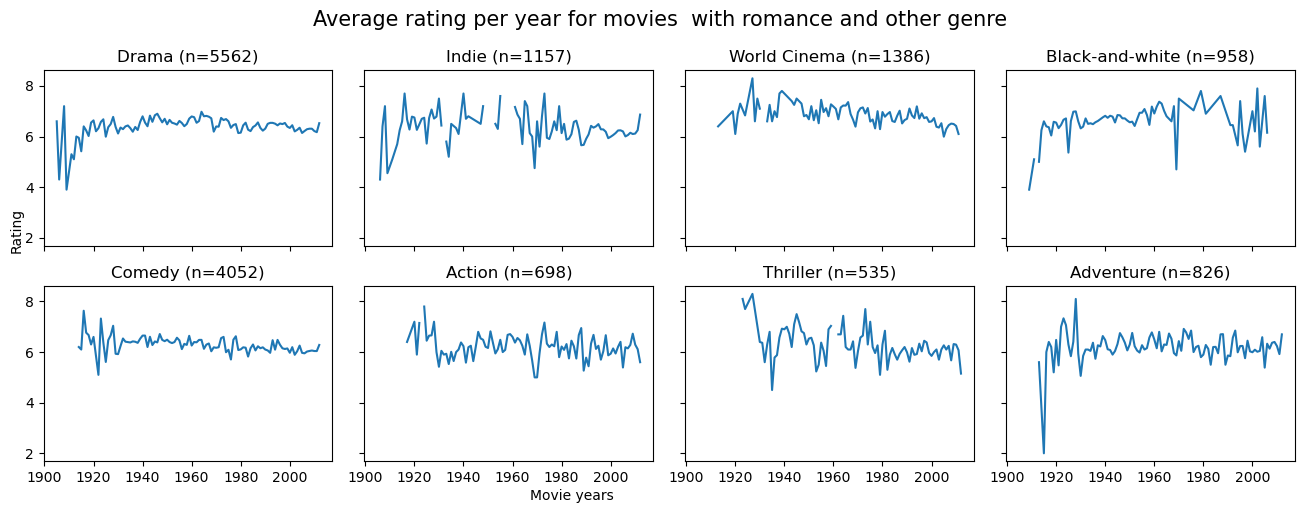

In [48]:
def panel(most_common, both_genres, starting_year=''):    
    fig, ax = plt.subplots(2,4,figsize= (13,5), sharey = True, sharex = True)
    for i, genre in enumerate(most_common):
        
        #we find the number of movies of romance and another genre and compute their average rating by year
        count = both_genres[genre]['rating'].count()
        average_rating_year = both_genres[genre].groupby(by='movie_release')['rating'].mean().reset_index()

        sbplt = ax[i%2, math.floor(i/2)]
        sbplt.plot(average_rating_year['movie_release'], average_rating_year['rating'])
        sbplt.set_title(f'{genre} (n={count})')

    fig.suptitle(f'Average rating per year for movies {starting_year} with romance and other genre', fontsize=15)
    fig.tight_layout()
    fig.text(0.4,0, "Movie years")
    fig.text(0,0.5, "Rating", rotation = 90)
    plt.show()

two_genres = get_two_genres(movies)
panel(most_common_genres, two_genres)

It is hard to compare, and we see that there is often a lot of variance in the earlier years, around 1900 to 1920. Additionally, for most of the genres, there is a lot of missing data before 1920. To facilitate comparison, let's see what happens after 1920 only:

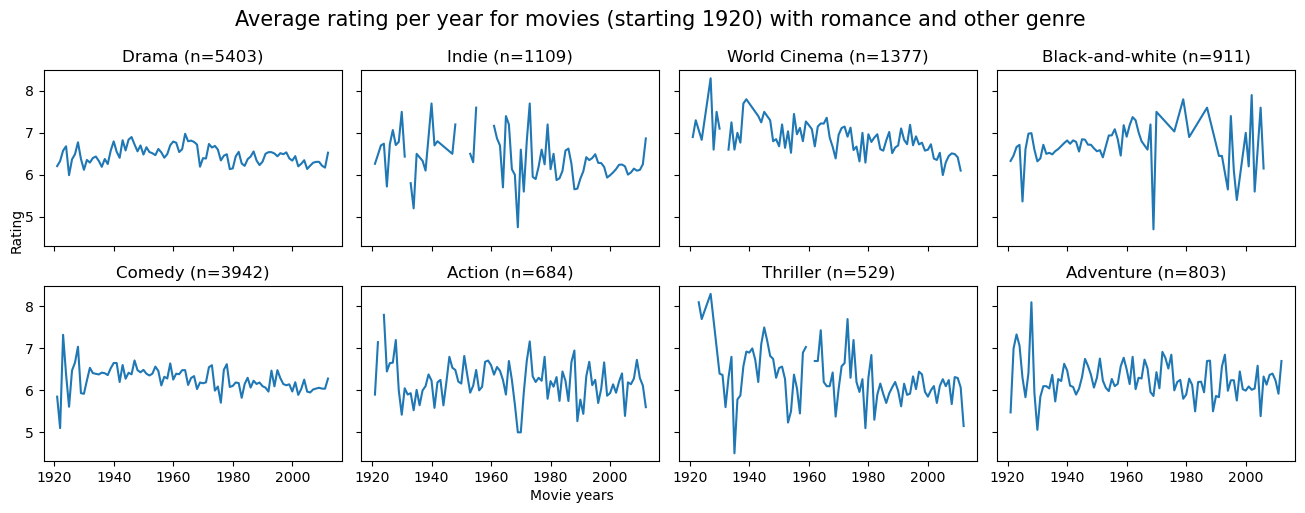

In [49]:
recents = movies[movies.movie_release>1920]
panel(most_common_genres, get_two_genres(recents), starting_year='(starting 1920)')

The plots are much easier to compare now. World cinema seems to be the genre that is best rated along with romance compared to the other genres. The thriller rating averages are very varied, which makes sense because there are fewest datapoints in that "Romance" and "Thriller" set. In contrast, "Drama" and "Romance", which was absolutely most common (logically so, since "Drama" is by far the most common genre overall) seems to have least variance. 

To see how many movies we removed, let's see how many romance movies there are after 1920 (compared to in total). As a reminder, we also show how many values we had before filtering the year.

In [50]:
romantic['rating'].count()

8432

In [51]:
romantic[romantic['movie_release']>1920]['rating'].describe()

count    8153.000000
mean        6.295940
std         0.937401
min         1.400000
25%         5.800000
50%         6.400000
75%         6.900000
max         9.200000
Name: rating, dtype: float64

We had 8400 movies before, now we only kept 8200. So only about 200 romance movies were released between 1900 and 1920, which justifies removing them just to make the plots clearer. Note that we did not adapt the most common genres as our goal was to "zoom" into the plot and not change the analysis. Also, it is unlikely that the ording would change by only removing 200 movies, so it probably would not change the analysis. Now, let us continue our analysis. We consider all romance movies, not just those after 1920.

Now, let's analyse the statistics of the ratings of the "paired up genres" dataframes overall (not over the years).

In [52]:
counts = {}
means = {}

for key, value in two_genres.items():
    counts[key] = value['rating'].describe()['count']
    means[key] = value['rating'].describe()['mean']
    print(f"For 'Romance' and '{key}', the rating statistics are \n{value['rating'].describe()}\n")

For 'Romance' and 'Drama', the rating statistics are 
count    5562.000000
mean        6.405843
std         0.900976
min         1.600000
25%         5.900000
50%         6.500000
75%         7.000000
max         9.200000
Name: rating, dtype: float64

For 'Romance' and 'Comedy', the rating statistics are 
count    4052.000000
mean        6.193608
std         0.921533
min         1.400000
25%         5.700000
50%         6.300000
75%         6.800000
max         9.200000
Name: rating, dtype: float64

For 'Romance' and 'Indie', the rating statistics are 
count    1157.000000
mean        6.209334
std         0.940652
min         1.400000
25%         5.700000
50%         6.300000
75%         6.800000
max         9.000000
Name: rating, dtype: float64

For 'Romance' and 'Action', the rating statistics are 
count    698.000000
mean       6.155301
std        1.015296
min        2.100000
25%        5.500000
50%        6.200000
75%        6.900000
max        8.300000
Name: rating, dtype: float64

Obviously (general knowledge), some genres (for example, "Comedy") are far more likely to also be romance movies than others. So proportionally to the total number of movies of a certain genre, let's see how many are also romance movies:

In [53]:
for genre in most_common_genres:
    total = len(movies[movies['genres'].apply(lambda genres: genre in genres)])
    perc = counts[genre]/total*100
    print(f"Out of {total} {genre.lower()} movies, {counts[genre]} are also romance movies ({perc:.2f}%)")

Out of 35285 drama movies, 5562.0 are also romance movies (15.76%)
Out of 21645 comedy movies, 4052.0 are also romance movies (18.72%)
Out of 13282 indie movies, 1157.0 are also romance movies (8.71%)
Out of 10113 action movies, 698.0 are also romance movies (6.90%)
Out of 9970 world cinema movies, 1386.0 are also romance movies (13.90%)
Out of 9116 thriller movies, 535.0 are also romance movies (5.87%)
Out of 9050 black-and-white movies, 958.0 are also romance movies (10.59%)
Out of 8919 adventure movies, 826.0 are also romance movies (9.26%)


Before, we looked at ratings against number of votes for all movies. Let's now do the same for romance movies.

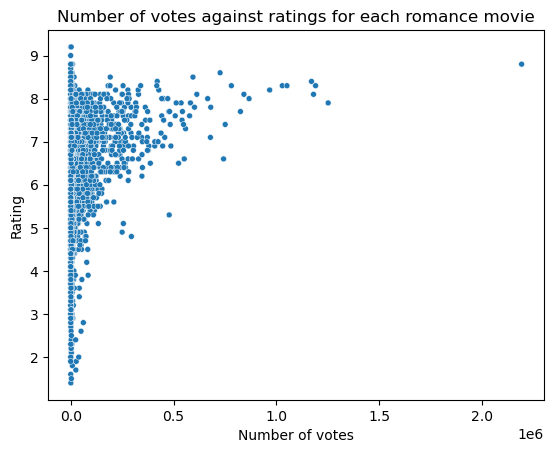

In [54]:
sns.scatterplot(data=romantic, x='nb_votes', y='rating' , size=0.1, legend=False)
plt.title('Number of votes against ratings for each romance movie')
plt.xlabel('Number of votes')
plt.ylabel('Rating')
plt.show()

The ratings based on the number of votes are roughly the same as before, it's just that the most romantic films are not the most highly rated (the scale does not even go up to 10, whereas it did before).

### Persona explanation and overview <a class="anchor" id="persona"></a>

The results of the LDA code being non-trivial to interpret, here is an overview of what they represent and how we can use them. In order to do so, we define a few functions to normalize and print the top indices of the data.

In [55]:
def normalize(data):
    return data/np.sum(data)

def top_n_indices(data, n):
    ind = np.argpartition(data, -n)[-n:]
    ind = ind[np.argsort(data[ind])][::-1]
    return ind

The data obtained from the LDA code is plit in different files. 
The file `lda_topics.tsv` contains the topics (words that cluster together) and their corresponding words, as well as the number of occurences. 

The file `persona.tsv` has been created by us and corresponds to the stacking of the data from the files `agents.tsv`, `patients.tsv` and `modifiee.tsv` which represent each 50 rows for each persona. The content of the row represent the ditribution of the persona over the different agents (for the first 50 rows), then over the patients, and then over the modifiees.

Note that these files are unfortunately not available to you as they were too big to put on git.

An *agent* is something the persona does, a *patient* is what is done to the persona, and a *modifiee* are adjectives associated with the persona. 

In [56]:
TOP_N_WORDS = 10
topics = np.ones((50,1000))

with open(path_lda +'lda.topics.tsv') as f:
    vocabulary = np.array(f.readline().split())
    i = 0
    
    for line in f:
        topics[i] = np.array(line.split(), dtype=float)
        i += 1

i=0
ind = np.argpartition(topics[i], -TOP_N_WORDS)[-TOP_N_WORDS:]
print('------------------\nThe top '+ str(TOP_N_WORDS) + ' words in topic ' + str(i) + ' are :') 
for index in top_n_indices(topics[i], TOP_N_WORDS) : 
    print(vocabulary[index], int(topics[i][index]))

FileNotFoundError: [Errno 2] No such file or directory: './Data/LDA/lda.topics.tsv'

In [ ]:
agents = np.ones((50,50))
patients = np.ones((50,50))
modifiee = np.ones((50,50))

with open(path_lda +'personas.tsv') as f:
    i = 0
    for line in f:
        # extracts the probabilities for each persona
        data = np.array(line.split('\t')[1].split(), dtype=float)
        agents[i] = normalize(data[:50])
        patients[i] = normalize(data[50:100])
        modifiee[i] = normalize(data[100:])
        
        i += 1

#### Case study : Persona 35 <a class="anchor" id="35"></a>

In [ ]:
def describe_persona(persona, topic_number=4):
    fig = plt.figure(figsize=(10, 2))

    plt.subplot(131)
    plt.title('Agents')
    plt.plot(agents[persona])

    plt.subplot(132)
    plt.title('Patients')
    plt.plot(patients[persona])

    plt.subplot(133)
    plt.title('Modifiee')
    plt.plot(modifiee[persona])

    fig.tight_layout()
    plt.show()

    top_agents_topics = top_n_indices(agents[persona], topic_number)
    top_patients_topics = top_n_indices(patients[persona], topic_number)
    top_modifiee_topics = top_n_indices(modifiee[persona], topic_number)

    print(f"The most important agent topics for persona {persona} are : ")
    for t in top_agents_topics : 
        top_words = top_n_indices(topics[t], 10)
        print('topic ' + str(t) + ' : ' + str(vocabulary[top_words]))
        
    print('\n-------------------')
    print(f"The most important patient topics for persona {persona} are : ")
    for t in top_patients_topics : 
        top_words = top_n_indices(topics[t], 10)
        print('topic ' + str(t) + ' : ' + str(vocabulary[top_words]))

    print('\n-------------------')
    print(f"The most important modifiee topics for persona {persona} are : ")
    for t in top_modifiee_topics : 
        top_words = top_n_indices(topics[t], 10)
        print('topic ' + str(t) + ' : ' + str(vocabulary[top_words]))

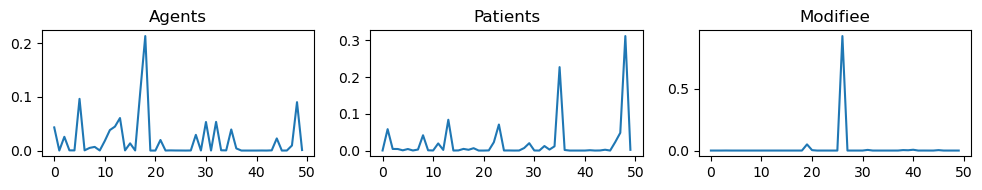

The most important agent topics for persona 35 are : 
topic 18 : ['escape' 'discover' 'manage' 'find' 'use' 'take' 'attempt' 'arrive'
 'learn' 'follow']
topic 17 : ['have' 'decide' 'be' 'go' 'try' 'find' 'make' 'lose' 'come' 'manage']
topic 5 : ['take' 'leave' 'tell' 'go' 'try' 'have' 'shoot' 'call' 'drive' 'arrive']
topic 48 : ['kill' 'shoot' 'capture' 'send' 'pursue' 'attack' 'lead' 'stop' 'wound'
 'track']

-------------------
The most important patient topics for persona 35 are : 
topic 48 : ['kill' 'shoot' 'capture' 'send' 'pursue' 'attack' 'lead' 'stop' 'wound'
 'track']
topic 35 : ['take' 'give' 'find' 'meet' 'bring' 'get' 'kill' 'help' 'join' 'tell']
topic 13 : ['kill' 'shoot' 'tell' 'confront' 'give' 'beat' 'ask' 'meet' 'threaten'
 'track']
topic 23 : ['name' 'call' 'go' 'leave' 'return' 'meet' 'be' 'have' 'kill' 'come']

-------------------
The most important modifiee topics for persona 35 are : 
topic 26 : ['officer' 'soldier' 'police' 'member' 'detective' 'guard' 'leader' '

In [ ]:
describe_persona(35)

Persona 35 is qualified as an officer, soldier... He escapes, discovers, finds, but he also shoots, captures, decide... He gets shot at, gets captured... This persona could be a soldier, but as we see that its most important agent topic is about escape and discovery, we deduce that he is in fact a secret agent. This is indeed validated by the `character.metadata.tsv` : James Bond is always classified as persona 35 ! 

#### Persona and genres <a class="anchor" id="persona_genre"></a>

From the preprocessing, our character dataframe also contains the most likely persona type for one character. As an exploratory analysis, it would be interesting to find out what distribution of persona types we have in our dataset. Let's start by looking at the distribution of persona types overall across the different genres. We will focus on romance afterwards.

In [ ]:
characters_genres = characters.merge(movies[['movie_id', 'genres', 'movie_name']], on='movie_id', how='left')

exploded = characters_genres.explode('genres') # obtain all the possible genres
pivot = exploded.groupby(['persona', 'genres']).size().reset_index(name='Count')
# pivot so we have genres as columns
pivot = pivot.pivot(index='persona', columns='genres', values='Count').fillna(0)
# normalize the values per column (genre) se we have values between 0 and 1
normalized = pivot.apply(lambda x: (x-x.min())/(x.max()-x.min()), axis=0)

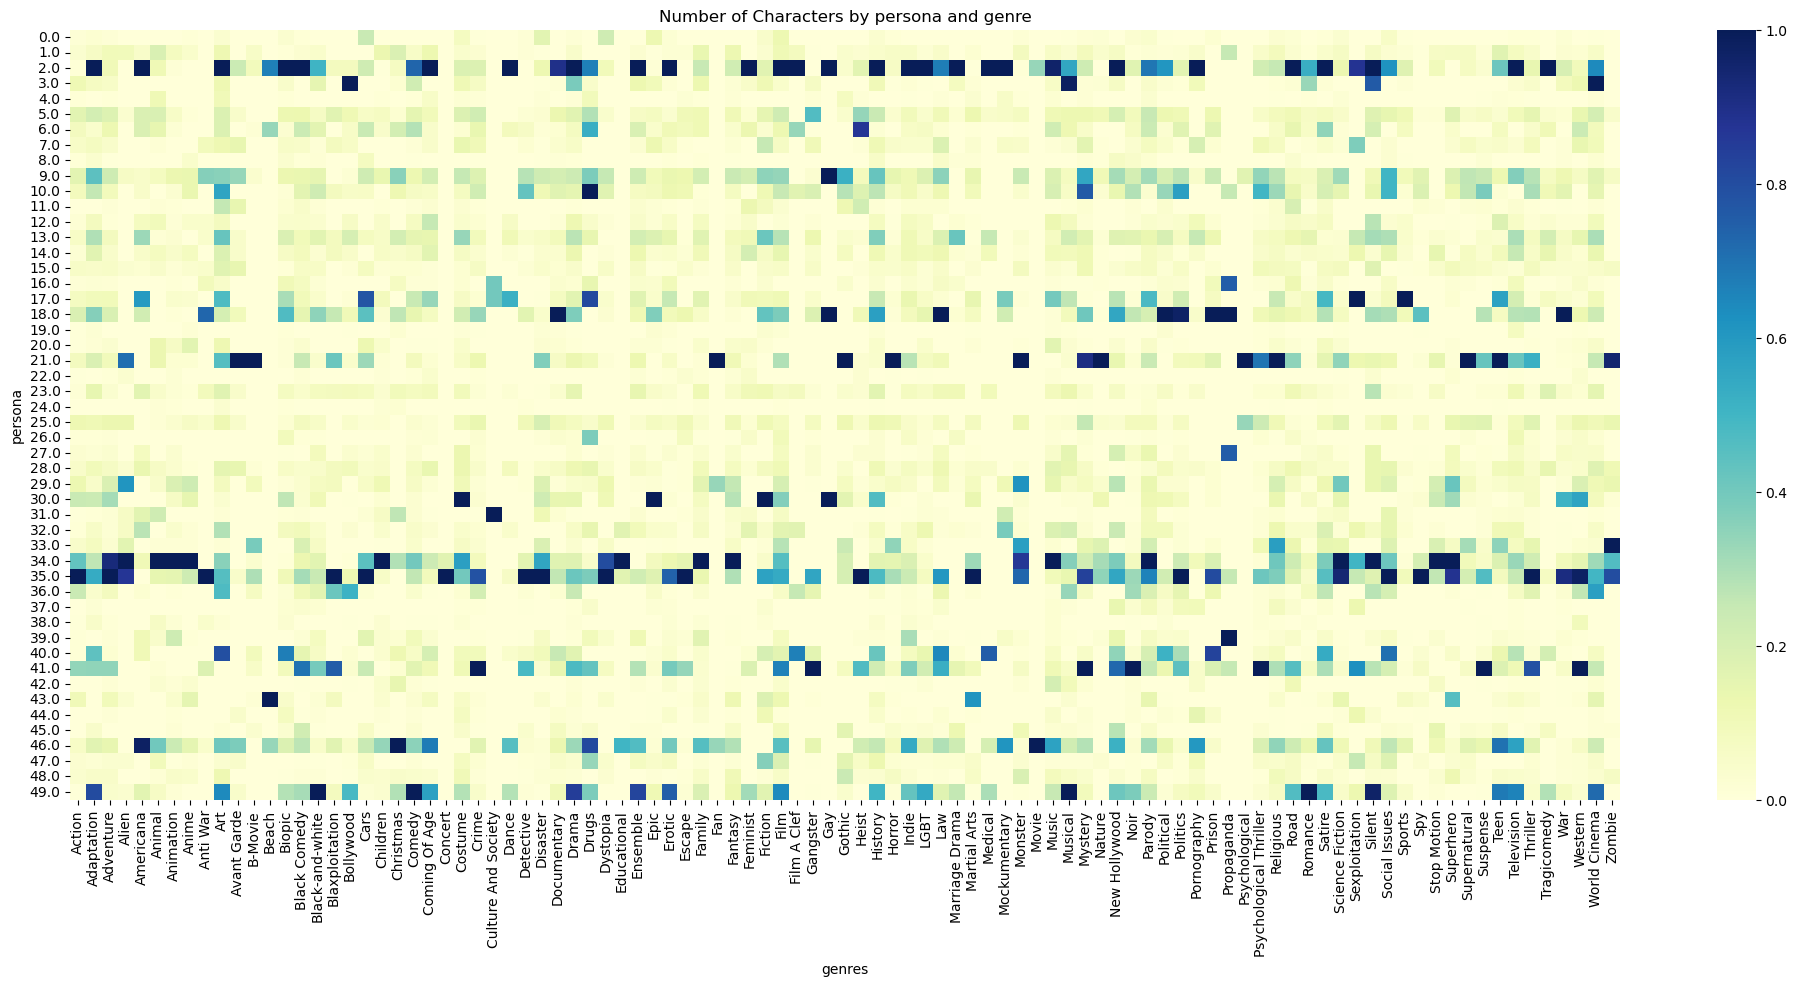

In [ ]:
plt.figure(figsize=(25, 10))
sns.heatmap(normalized, annot=False, cmap='YlGnBu', fmt='g')
plt.title('Number of Characters by persona and genre')
plt.show()

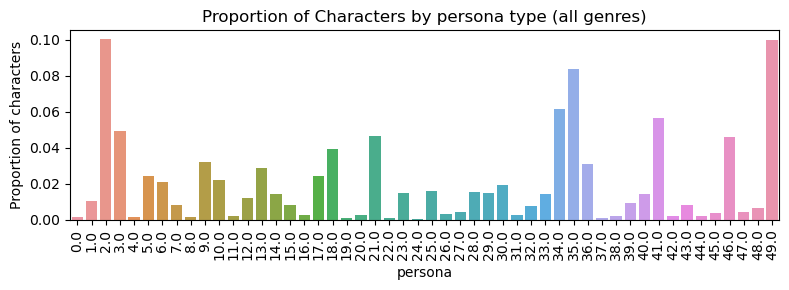

In [ ]:
persona_count = characters_genres.groupby('persona').size().reset_index(name='Count')
persona_total = persona_count['Count'].sum()
persona_count['Proportion'] = persona_count['Count'].apply(lambda x: x/persona_total)

plt.figure(figsize=(8, 3))
sns.barplot(data=persona_count, x='persona', y='Proportion', errorbar=None)
plt.title('Proportion of Characters by persona type (all genres)')
plt.xticks(rotation = 90) # Rotates X-Axis Ticks
plt.ylabel('Proportion of characters')
plt.tight_layout()
plt.show()

#### Persona and romance <a class="anchor" id="Persona_romance"></a>

Now that we have a sense of the persona, let's see how it goes in romance. What kind of personas are most common in romance movies? Let's start by looking at the distribution of personas in romance movies.

In [ ]:
romance_genres = get_genres(romantic)
romance_list = list(set(romance_genres.keys())&set(pivot.columns))
len(romance_list)

94

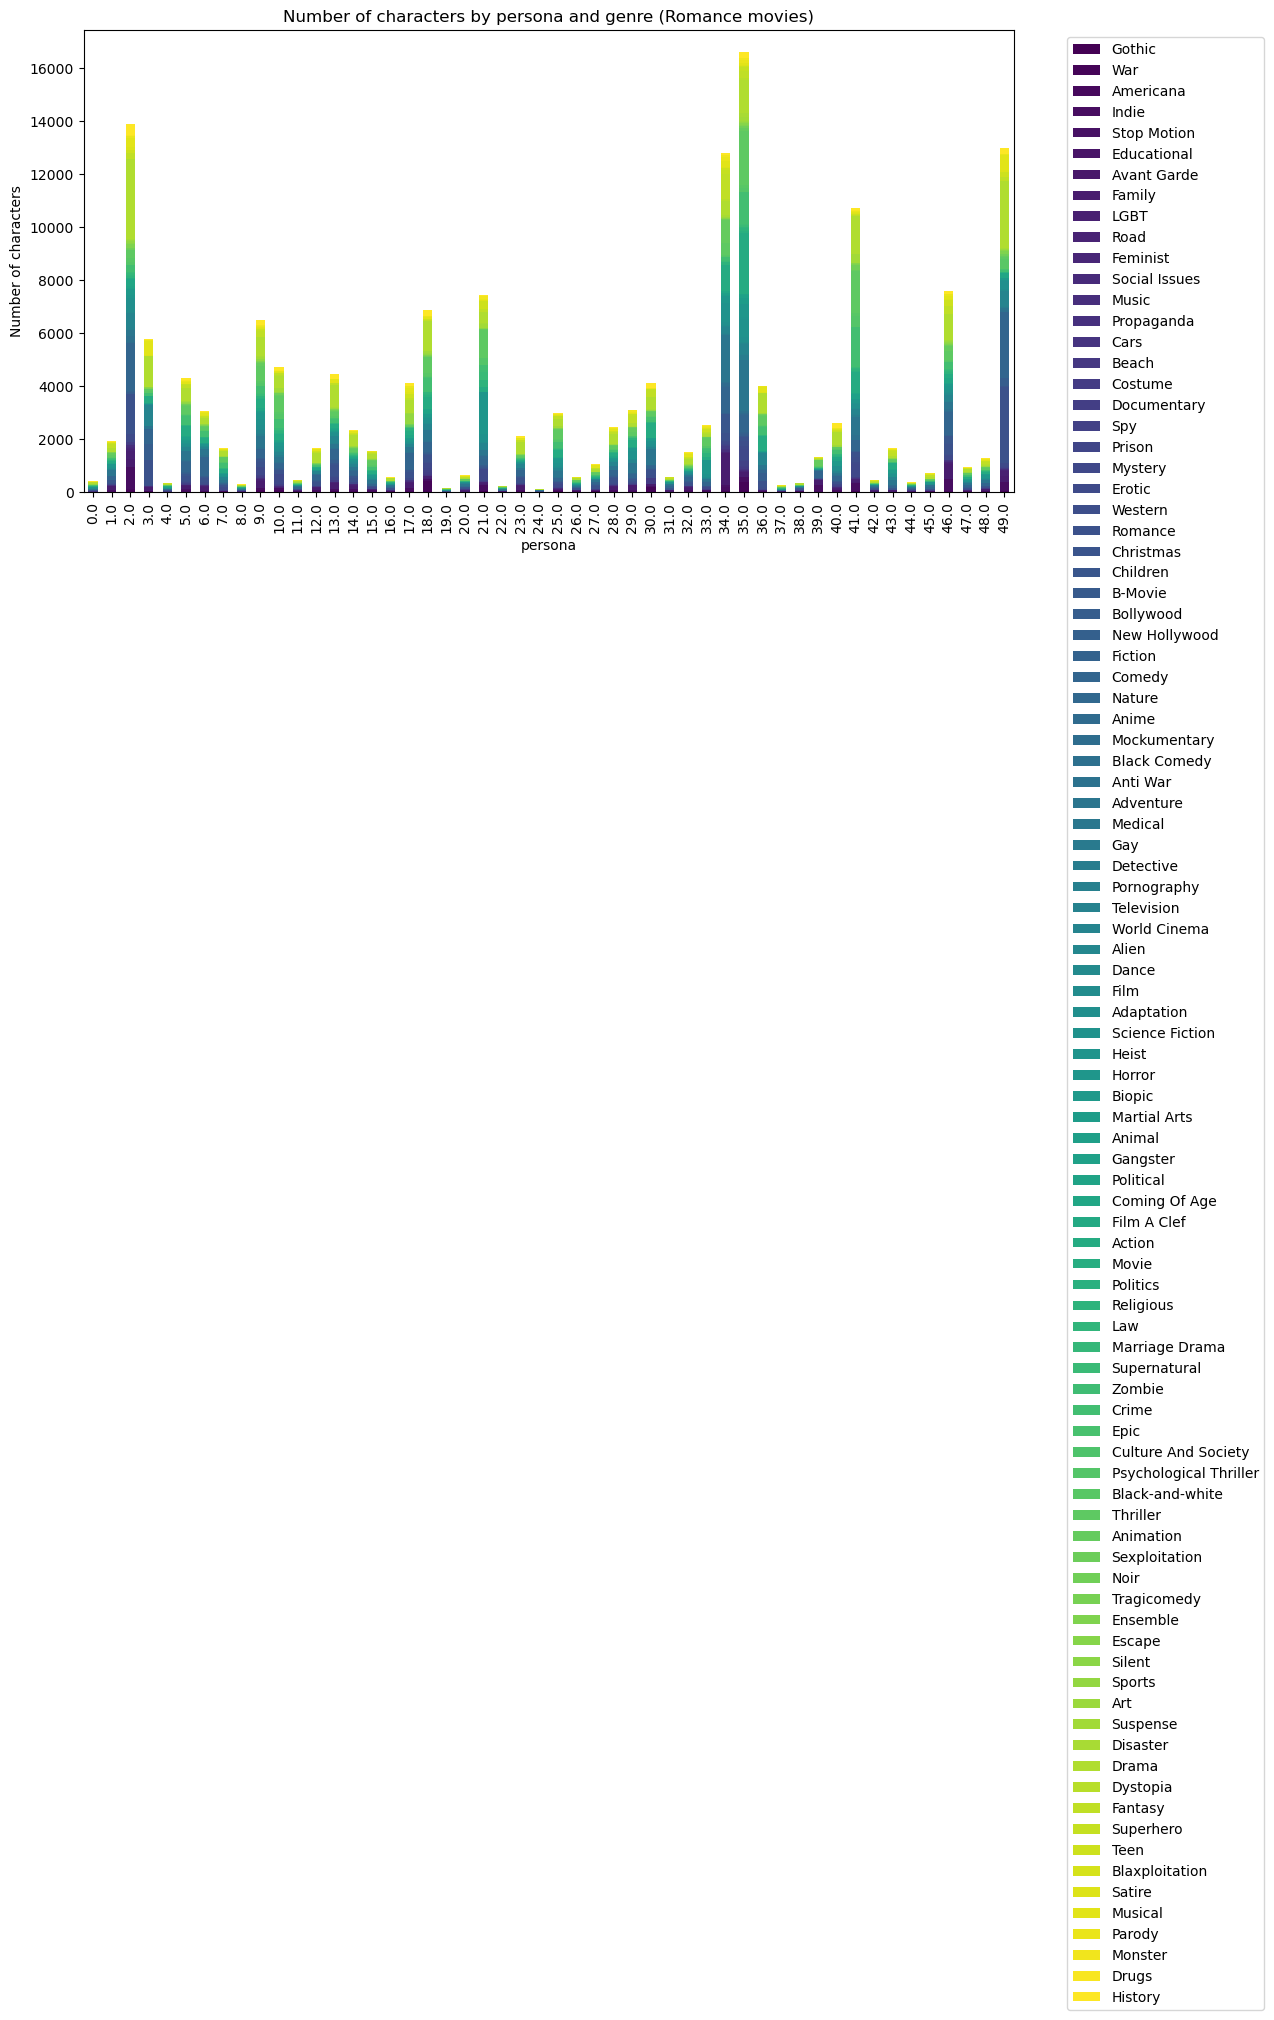

In [ ]:
pivot[romance_list].plot(kind='bar', stacked=True, colormap='viridis', figsize=(12, 6), legend=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Number of characters by persona and genre (Romance movies)')
plt.ylabel('Number of characters')
plt.show()

As the legend for this plot is very long (94 different genres), any plotting is not very clear. Let's focus on a few selected genres, chosen kind of arbitrarily.

In [ ]:
romance_list2 = ['Romance', 'Comedy', 'Drama', 'Fantasy', 'Action', 'Teen',
                'Adventure', 'Marriage Drama', 'Pornography', 'LGBT']

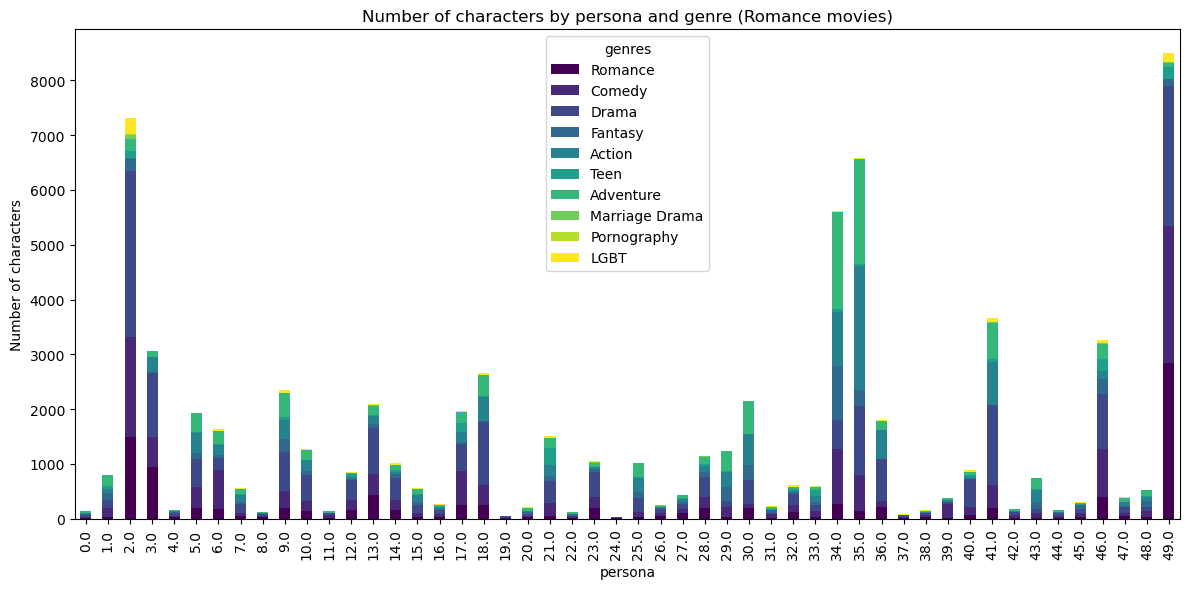

In [ ]:
pivot[romance_list2].plot(kind='bar', stacked=True, colormap='viridis', figsize=(12, 6))
plt.title('Number of characters by persona and genre (Romance movies)')
plt.ylabel('Number of characters')
plt.tight_layout()
plt.show()

We can observe that the patterns of persona distribution is very similar in between the romance movies and the overall movies. This could be explained by the fact that in a lot of genres, movies contain some elements of romance.

Let's see what happens if we divide the number of occurences of each persona in romance by the total number of occurence of the persona in all genres.

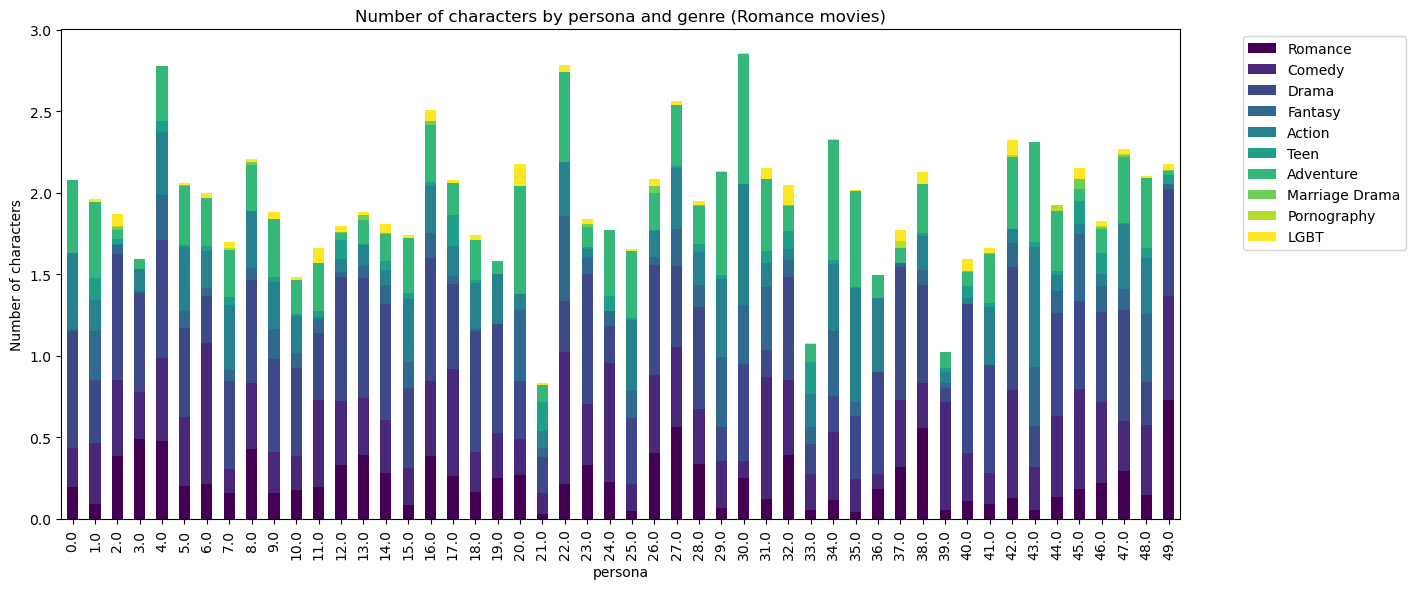

In [ ]:
numbers = pivot.div(list(persona_count['Count']), axis=0)

numbers[romance_list2].plot(kind='bar', stacked=True, colormap='viridis', figsize=(12, 6))
plt.title('Number of characters by persona and genre (Romance movies)')
plt.ylabel('Number of characters')
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

We can observe a significant difference, as the persona 21 which was very representated is now much less relevant. 
In the *Romance* genre, we can see that persona 49, 3 and 27 seem to be pretty present. Let's see what they represent.

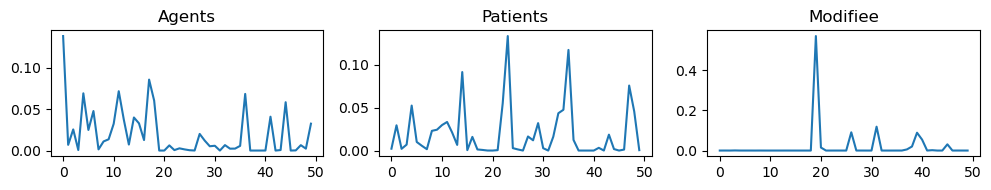

The most important agent topics for persona 27 are : 
topic 0 : ['find' 'realize' 'leave' 'decide' 'want' 'agree' 'see' 'take' 'try'
 'have']
topic 17 : ['have' 'decide' 'be' 'go' 'try' 'find' 'make' 'lose' 'come' 'manage']
topic 11 : ['get' 'see' 'run' 'take' 'come' 'be' 'look' 'turn' 'make' 'start']
topic 4 : ['love' 'tell' 'be' 'marry' 'leave' 'confess' 'run' 'break' 'go' 'propose']
topic 36 : ['give' 'return' 'leave' 'fall' 'find' 'discover' 'grow' 'flee'
 'encounter' 'join']
topic 18 : ['escape' 'discover' 'manage' 'find' 'use' 'take' 'attempt' 'arrive'
 'learn' 'follow']

-------------------
The most important patient topics for persona 27 are : 
topic 23 : ['name' 'call' 'go' 'leave' 'return' 'meet' 'be' 'have' 'kill' 'come']
topic 35 : ['take' 'give' 'find' 'meet' 'bring' 'get' 'kill' 'help' 'join' 'tell']
topic 14 : ['marry' 'fall' 'meet' 'love' 'engage' 'take' 'propose' 'send' 'kidnap'
 'attract']
topic 47 : ['save' 'rescue' 'capture' 'take' 'find' 'kidnap' 'reunite' 'free'
 

In [ ]:
describe_persona(27, 6)

It is hard to tell exactly what the persona represent. However, it has been assigned to Tiana (the princess and the frog), Mary-Jane Watson (Spiderman) and Scarlet O'Hara (Gone with the Wind).

We can thus hypothetize that persona 27 is an independent persona, with a strong character.

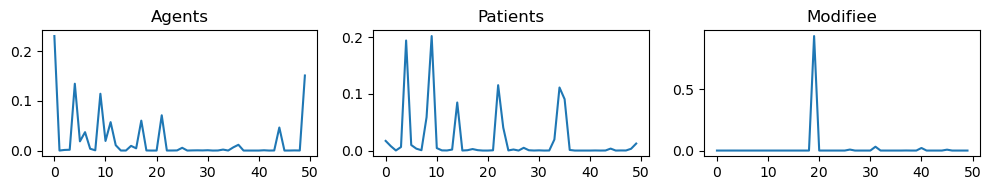

The most important agent topics for persona 49 are : 
topic 0 : ['find' 'realize' 'leave' 'decide' 'want' 'agree' 'see' 'take' 'try'
 'have']
topic 49 : ['go' 'say' 'have' 'be' 'leave' 'know' 'want' 'do' 'come' 'ask']
topic 4 : ['love' 'tell' 'be' 'marry' 'leave' 'confess' 'run' 'break' 'go' 'propose']
topic 9 : ['tell' 'ask' 'give' 'meet' 'call' 'see' 'show' 'get' 'talk' 'take']
topic 21 : ['have' 'begin' 'discover' 'make' 'move' 'take' 'work' 'feel' 'fall'
 'learn']
topic 17 : ['have' 'decide' 'be' 'go' 'try' 'find' 'make' 'lose' 'come' 'manage']

-------------------
The most important patient topics for persona 49 are : 
topic 9 : ['tell' 'ask' 'give' 'meet' 'call' 'see' 'show' 'get' 'talk' 'take']
topic 4 : ['love' 'tell' 'be' 'marry' 'leave' 'confess' 'run' 'break' 'go' 'propose']
topic 22 : ['see' 'visit' 'do' 'convince' 'look' 'shock' 'inform' 'introduce'
 'confront' 'help']
topic 34 : ['meet' 'attract' 'marry' 'leave' 'seduce' 'force' 'involve' 'reunite'
 'introduce' 'offer']
t

In [ ]:
describe_persona(49, 6)

The modifiee topics are the same as for the persona 35. After some analysis, we noticed that this also seems to be the case for the other personas. Based on this, we consider them irrelevant for our analysis and disregard them.

Persona 49 is hard to analyse as well and is present in numerous different and less known movies, which makes the analysis even harder. Let's just for now assume that it represent one central romance character archetype.

# Regression on persona

Let's try to include the persona in our regression. Each movie dosn't have a persona for each character, thus the need to also include the number of actors playing in the movie as a comparison. 

> also the regression suckkkkkks try another model? feature transformation?

In [ ]:
movies_persona = characters.groupby('movie_id')[['persona', 'a_name']].nunique().reset_index()
# drop the movies with no characters to avoid division by 0
movies_persona = movies_persona.drop(movies_persona[movies_persona['a_name']==0].index) 
movies_persona.a_name = movies_persona.persona.div(movies_persona.a_name, axis=0)
movies_persona = movies_persona.rename(columns={"persona": "nb_personas", "a_name": "ratio"})
movies_persona.head()

In [ ]:
movies = movies.merge(movies_persona, on='movie_id', how='left')
movies.head()

In [ ]:
movies_regression = movies[movies.nb_personas != 0]
movies_regression = movies_regression[movies_regression.rating.notna()] # shape (22465, 13)
movies_regression = movies_regression[movies_regression.ratio.notna()] # shape (12689, 13)
movies_regression = movies_regression[movies_regression.runtime.notna()]
movies_regression = movies_regression[movies_regression.nb_votes.notna()] #shape (12170, 13)

In [ ]:
model = smf.ols(formula='rating ~ nb_personas * ratio * runtime + nb_votes', data=movies_regression)
results = model.fit()
results.summary()